# Micromagnetic model

## Mesh

The mesh is defined by three parameters:

1. points `p1` and `p2` between which the mesh domain spans,
2. discretisation cell size `cell`.

There is also an optional `name` argument. For instance, if the mesh spans between `p1 = (0, 0, 0)` and `p2 = (100e-9, 100e-9, 10e-9)` and the discretisation cell is `cell = (5e-9, 5e-9, 5e-9)`, we create the mesh as:

In [1]:
import oommfc as oc

mesh = oc.Mesh(p1=(0, 0, 0), p2=(100e-9, 100e-9, 10e-9), cell=(10e-9, 10e-9, 10e-9), name="mesh")
mesh

The domain edge lengths in x, y, and z directions are:

In [2]:
mesh.l

(1e-07, 1e-07, 1e-08)

The number of cells in all three directions:

In [3]:
mesh.n

(10, 10, 1)

The centre point of the mesh:

In [4]:
mesh.centre

(5e-08, 5e-08, 5e-09)

To show the mesh domain and discretisation cell:

In [5]:
mesh

If we want to iterate through all mesh coordinates, there is `coordinates` generator:

In [6]:
for coord in mesh.coordinates():
    print(coord)

(5e-09, 5e-09, 5e-09)
(1.5000000000000002e-08, 5e-09, 5e-09)
(2.5e-08, 5e-09, 5e-09)
(3.5e-08, 5e-09, 5e-09)
(4.5e-08, 5e-09, 5e-09)
(5.5e-08, 5e-09, 5e-09)
(6.5e-08, 5e-09, 5e-09)
(7.5e-08, 5e-09, 5e-09)
(8.500000000000001e-08, 5e-09, 5e-09)
(9.5e-08, 5e-09, 5e-09)
(5e-09, 1.5000000000000002e-08, 5e-09)
(1.5000000000000002e-08, 1.5000000000000002e-08, 5e-09)
(2.5e-08, 1.5000000000000002e-08, 5e-09)
(3.5e-08, 1.5000000000000002e-08, 5e-09)
(4.5e-08, 1.5000000000000002e-08, 5e-09)
(5.5e-08, 1.5000000000000002e-08, 5e-09)
(6.5e-08, 1.5000000000000002e-08, 5e-09)
(7.5e-08, 1.5000000000000002e-08, 5e-09)
(8.500000000000001e-08, 1.5000000000000002e-08, 5e-09)
(9.5e-08, 1.5000000000000002e-08, 5e-09)
(5e-09, 2.5e-08, 5e-09)
(1.5000000000000002e-08, 2.5e-08, 5e-09)
(2.5e-08, 2.5e-08, 5e-09)
(3.5e-08, 2.5e-08, 5e-09)
(4.5e-08, 2.5e-08, 5e-09)
(5.5e-08, 2.5e-08, 5e-09)
(6.5e-08, 2.5e-08, 5e-09)
(7.5e-08, 2.5e-08, 5e-09)
(8.500000000000001e-08, 2.5e-08, 5e-09)
(9.5e-08, 2.5e-08, 5e-09)
(5e-09, 3

## System

The basic block of our micromagnetic model is the system object. It is fully defined if:

1. Hamiltonian,
2. dynamics equation,
3. magnetisation.

are provided. The system is then "driven" in phase space using particular drivers.

In [7]:
system = oc.System(name="system")

## Hamiltonian

In [8]:
exchange = oc.Exchange(A=1e-12)

In [9]:
exchange

Exchange(A=1e-12)

In [10]:
exchange.A

1e-12

In [11]:
repr(exchange)

'Exchange(A=1e-12)'

In [12]:
hamiltonian = exchange + oc.Zeeman(H=(1e6, 0, 0))

type(hamiltonian)

oommfc.hamiltonian.hamiltonian.Hamiltonian

In [13]:
system.hamiltonian = hamiltonian

In [14]:
system.hamiltonian

Exchange(A=1e-12) + Zeeman(H=(1000000.0, 0, 0))

In [15]:
system.hamiltonian.exchange.A

1e-12

In [16]:
system.hamiltonian.zeeman.H

(1000000.0, 0, 0)

In [17]:
system.hamiltonian += oc.Demag(name="energy_term_name")

In [18]:
system.hamiltonian.energy_term_name

Demag()

## Dynamics

In [19]:
system.dynamics = oc.Precession(gamma=2.211e5) + oc.Damping(alpha=0.1)

In [20]:
system.dynamics

Precession(gamma=221100.0) + Damping(alpha=0.1)

## Magnetisation

In [21]:
import discretisedfield as df

In [22]:
Ms = 8e5
m = df.Field(mesh, value=(1, 0, 1), norm=Ms, name="m")

In [23]:
m  # representation to be decided

Field(dim=3, name="m")

In [24]:
p = (50e-9, 50e-9, 5e-9)
m(p)  # sampling

array([ 565685.42494924,       0.        ,  565685.42494924])

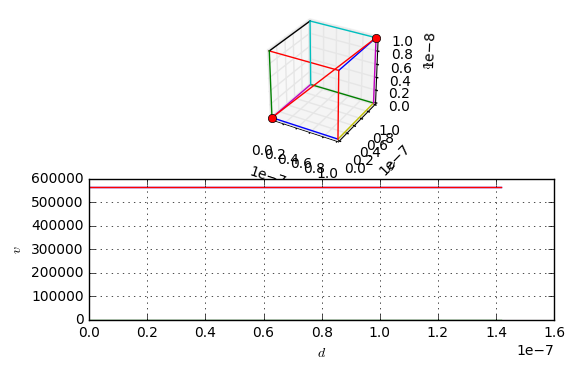

In [25]:
%matplotlib inline
fig = m.plot_line_intersection(l=(100, 100, 10), l0=(0, 0, 0))

In [26]:
m.f = lambda pos: (pos[0]+pos[2]+1, pos[2], 0)

In [27]:
system.m = m

## Drivers

### MinDriver

In [28]:
md = oc.MinDriver()
md.drive(system)

In [29]:
system.m.average

(799861.70786910132, 6.5483618527650831e-13, 0.00016779476496086212)

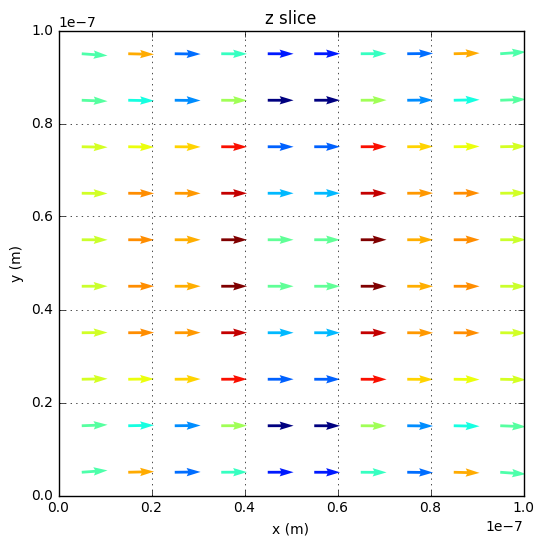

In [30]:
fig = system.m.plot_slice("z", 5e-9, xsize=6)

In [31]:
system.hamiltonian.zeeman.H = (0, 1e7, 0)

In [32]:
md.drive(system)

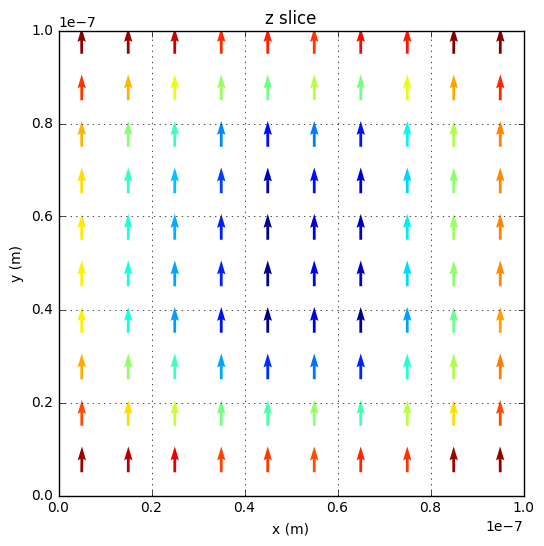

In [33]:
fig = system.m.plot_slice("z", 5e-9, xsize=6)

### Time driver

In [34]:
system.hamiltonian += oc.UniaxialAnisotropy(K=5e3, u=(0, 0, 1))
system.hamiltonian.zeeman.H = (1e6, 0, 0)

In [35]:
td = oc.TimeDriver()
td.drive(system, t=0.2e-9, n=50)

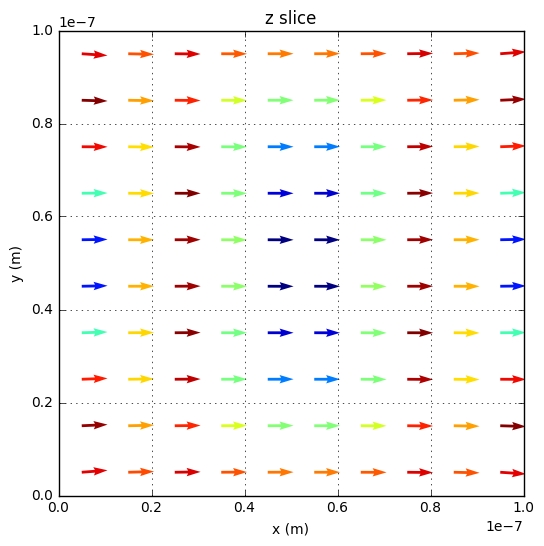

In [36]:
fig = system.m.plot_slice("z", 5e-9, xsize=6)

In [37]:
system.dt

,E,Ecount,max_dm/dt,dE/dt,deltaE,Eex,max_spin_angle,stage_max_spin_angle,run_max_spin_angle,FixedZeeman:zeeman:Energy,Ed,Ea,iteration,stage_iteration,stage,mx,my,mz,last_time_step,t
0,-4.972610e-18,49.0,14057.500049,-2.578684e-06,-2.528878e-18,1.252986e-21,4.126862,4.126862,4.126862,-2.484543e-17,1.964860e-17,2.229673e-19,8.0,8.0,0.0,0.247142,0.619203,0.744266,1.005901e-12,4.000000e-12
1,-1.584101e-17,62.0,14474.432247,-2.708337e-06,-5.303029e-18,4.085149e-21,7.415927,7.415927,7.415927,-4.079526e-17,2.482147e-17,1.286965e-19,11.0,2.0,1.0,0.405798,-0.297712,0.861187,1.925836e-12,8.000000e-12
2,-2.543848e-17,75.0,13233.615972,-2.064432e-06,-3.576564e-18,4.184822e-21,7.347229,7.415927,7.415927,-3.148853e-17,5.577776e-18,4.680872e-19,14.0,2.0,2.0,0.313222,-0.915128,0.243306,1.632458e-12,1.200000e-11
3,-3.360894e-17,88.0,13101.737005,-2.204817e-06,-3.420119e-18,6.278809e-21,9.597474,9.597474,9.597474,-4.581259e-17,1.183404e-17,3.633233e-19,17.0,2.0,3.0,0.455706,-0.717409,-0.519160,1.625381e-12,1.600000e-11
4,-4.310181e-17,101.0,13549.102685,-2.374196e-06,-3.869884e-18,1.519513e-20,14.382220,14.382220,14.382220,-6.334258e-17,2.001285e-17,2.127258e-19,20.0,2.0,4.0,0.630080,0.102439,-0.757062,1.598025e-12,2.000000e-11
5,-5.119952e-17,114.0,12117.920228,-1.635868e-06,-2.817490e-18,2.049784e-20,18.048693,18.048693,18.048693,-5.814086e-17,6.471562e-18,4.492841e-19,23.0,2.0,5.0,0.578338,0.746069,-0.290293,1.580972e-12,2.400000e-11
6,-5.732102e-17,127.0,11814.620873,-1.604232e-06,-2.350614e-18,2.412813e-20,19.955864,19.955864,19.955864,-6.613695e-17,8.369740e-18,4.220598e-19,26.0,2.0,6.0,0.657876,0.635751,0.365732,1.524156e-12,2.800000e-11
7,-6.417501e-17,140.0,11997.096980,-1.685099e-06,-2.550261e-18,3.876388e-20,24.482057,24.482057,24.482057,-7.818574e-17,1.364597e-17,3.259877e-19,29.0,2.0,7.0,0.777728,-0.041192,0.587635,1.470535e-12,3.200000e-11
8,-6.974677e-17,153.0,10543.105314,-1.094213e-06,-1.561713e-18,4.549471e-20,27.121779,27.121779,27.121779,-7.607791e-17,5.823583e-18,4.620613e-19,32.0,2.0,8.0,0.756761,-0.568713,0.227347,1.321771e-12,3.600000e-11
9,-7.381945e-17,166.0,10008.892870,-1.056136e-06,-1.356852e-18,4.435046e-20,26.825496,27.121779,27.121779,-8.137343e-17,7.068817e-18,4.408103e-19,35.0,2.0,9.0,0.809436,-0.469852,-0.271835,1.322114e-12,4.000000e-11


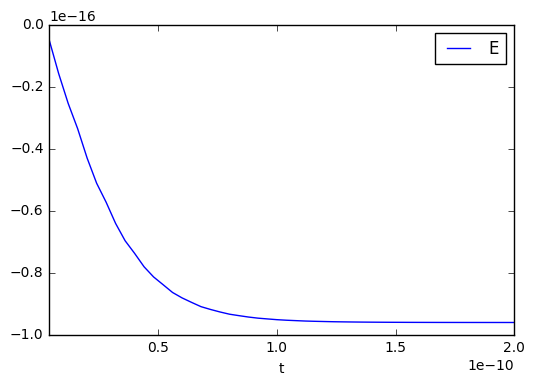

In [38]:
system.dt.plot("t", "E")